In [1]:
!pip install --quiet pandas numpy scikit-learn matplotlib seaborn tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
# Simulate tabular data (100 samples, 5 features)
np.random.seed(42)
tabular_data = pd.DataFrame({
    'area': np.random.randint(800, 4000, 100),
    'bedrooms': np.random.randint(1, 5, 100),
    'bathrooms': np.random.randint(1, 4, 100),
    'garage': np.random.randint(0, 3, 100),
    'age': np.random.randint(0, 20, 100),
    'price': np.random.randint(100000, 500000, 100)
})

# Simulate random images (100 RGB 64x64 images)
image_data = np.random.randint(0, 256, (100, 64, 64, 3)).astype('float32') / 255.0

# Separate features and target
X_tabular = tabular_data.drop(columns=['price'])
y = tabular_data['price']


In [3]:
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)

# Train-test split
X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tabular_scaled, image_data, y, test_size=0.2, random_state=42
)


In [4]:
# Image branch
img_input = Input(shape=(64, 64, 3))
x = Conv2D(32, (3,3), activation='relu')(img_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

# Tabular branch
tab_input = Input(shape=(X_tab_train.shape[1],))
y = Dense(32, activation='relu')(tab_input)
y = Dense(16, activation='relu')(y)

# Combine
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(1)(z)

# Model
model = Model(inputs=[img_input, tab_input], outputs=z)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12560)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │    803,904 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 824,081 (3.14 MB)

 Trainable params: 824,081 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=8
)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - loss: 91557388288.0000 - mae: 278283.5312 - val_loss: 68201570304.0000 - val_mae: 242112.8438
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 77214523392.0000 - mae: 255338.7188 - val_loss: 67664388096.0000 - val_mae: 241000.7500
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 80842366976.0000 - mae: 261993.1719 - val_loss: 65967345664.0000 - val_mae: 237453.2188
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 76972105728.0000 - mae: 252604.1250 - val_loss: 61813514240.0000 - val_mae: 228537.6406
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 80503734272.0000 - mae: 255218.4688 - val_loss: 53377351680.0000 - val_mae: 209263.8750
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 67277443072.0000 - mae: 229763.7969 - val_loss: 39358193664.0000 - val_mae: 172534.0938
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 54069551104.0000 - mae: 200314.1094 - val_loss: 21561972736.0000 -

In [6]:
# Predict and evaluate
y_pred = model.predict([X_img_test, X_tab_test])
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
MAE: 115846.65
RMSE: 134966.99


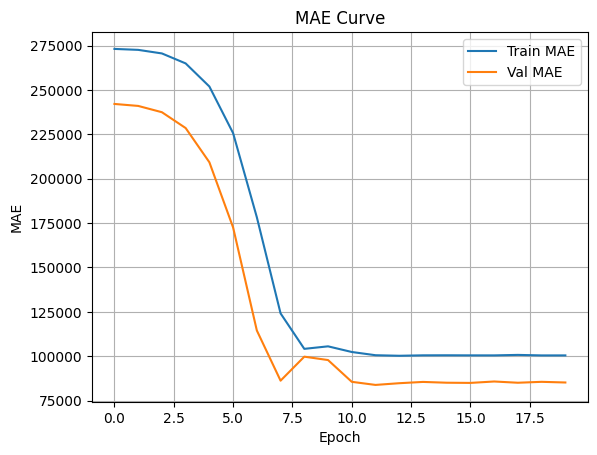

In [7]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE Curve')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.show()
